# TextRank statistics
Statistics for the data of how the sentences that the answers appear in rank (according to textrank applied to the paragraphs)

https://github.com/dailykirt/ML_Enron_email_summary/blob/master/notebooks/Text_rank_summarization.ipynb

Swedish bert model:
https://huggingface.co/KB/bert-base-swedish-cased

Alternative: https://huggingface.co/KBLab/sentence-bert-swedish-cased, with description: https://kb-labb.github.io/posts/2021-08-23-a-swedish-sentence-transformer/

https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2

Idea for creating embeddings for a sentence: https://discuss.huggingface.co/t/generate-raw-word-embeddings-using-transformer-models-like-bert-for-downstream-process/2958

good library for language features? https://spacy.io/usage/linguistic-features#vectors-similarity

In [1]:
import pandas as pd
from transformers import AutoModel,AutoTokenizer
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt

# for sentence tokenization
import nltk as nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# for textrank:
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [21]:
# load the data
df_train = pd.read_pickle("./data_frames/df_train.pkl")
df_test = pd.read_pickle("./data_frames/df_test.pkl")

In [22]:

tokenizer = AutoTokenizer.from_pretrained('KB/bert-base-swedish-cased', do_lower_case=True)
# model = AutoModel.from_pretrained('KB/bert-base-swedish-cased')
model = SentenceTransformer('KBLab/sentence-bert-swedish-cased')

In [23]:
def remove_stopwords_and_get_embedding(sentences, remove_stopwords=False):
    tok_sentences = []
    for sent in sentences:
        # should use bert tokenizer?
        if remove_stopwords:
            sent = remove_stopwords_sentence(sent)
        # using BERT tokenizer
        tok_sent = tokenizer.tokenize(sent)
        clean_sent = ' '.join(tok_sent)
        tok_sentences.append(clean_sent)
    return tok_sentences

# Alternative to using the BERT tokenizer -- removes stopwords. Use together?
def remove_stopwords_sentence(sentence):
 
    stop_words = set(stopwords.words('swedish'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence = []
    
    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
    
    return ' '.join(filtered_sentence)

In [24]:
# function to rank sentences by textrank
# from https://github.com/dailykirt/ML_Enron_email_summary/blob/master/notebooks/Text_rank_summarization.ipynb
def rank_sentences(sentences, sentence_vectors):
    '''This function takes in a list of sentences to input into TextRank. The resulting ranks are what the model 
    calculated as the most important sentences. '''
    sim_mat = np.zeros([len(sentences), len(sentences)])
    #Initialize matrix with cosine similarity scores. 
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i != j:
                shape_len = len(sentence_vectors[i])
                sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,shape_len), sentence_vectors[j].reshape(1,shape_len))[0,0]
    nx_graph = nx.from_numpy_array(sim_mat)
    
    #Pair sentence with it's similarity score then sort.    
    try:
        scores = nx.pagerank(nx_graph)
        ranked_sentences = sorted(((scores[i],s[0], s[1]) for i,s in enumerate(sentences)), reverse=True)
    except:
        ranked_sentences = sorted(((0,s[0], s[1]) for i,s in enumerate(sentences)), reverse=True)

    return ranked_sentences

In [25]:
# tokenize the data
# https://huggingface.co/docs/transformers/quicktour
def encode_context_sentences(df, remove_stopwords=False):
    first_match = 0
    top_match = 0
    results_df = pd.DataFrame(columns=['answer', 'answer_loc', 'top_textrank_sent', 'top_textrank_loc', 'top_textrank_match', 'top_3_textrank_sents', 'top_3_textrank_loc', 'top_3_textrank_match', 'all_textrank_sents'])
    for index, row in df.iterrows():
        answer = row['correct_answer'].lower()
        loc = row['answer_location']
        text = row['context'].lower()
        # split the text into sentences
        text = text.replace("\r\n",". ")
        text = text.replace("\n",". ")
        text = text.replace("..",".")
        sentences = sent_tokenize(text)
        tok_context = remove_stopwords_and_get_embedding(sentences, remove_stopwords)
        
        # Encode sentences using Sentence BERT
        embeddings = model.encode(tok_context)
        embeddings = np.array(embeddings)
    
        # run textrank on the embeddings
        # Make sentences tuple also containing ids to keep track of idx of sentences
        sent_tuples = [ (s, i) for i,s in enumerate(tok_context) ] # array of tuples (sentence, idx)
        ranked = rank_sentences(sent_tuples, embeddings)
        top_3_textrank_loc = [s[2] for s in ranked[:3] ]
        df_row = {'answer': answer, 'answer_loc': loc, 'top_textrank_sent': ranked[0], 'top_textrank_loc': ranked[0][2], 'top_textrank_match': False,
            'top_3_textrank_sents':ranked[:3], 'top_3_textrank_loc': top_3_textrank_loc , 'top_3_textrank_match': False, 'all_textrank_sents': ranked, 'sentence_tuples': sent_tuples, 'sentence_embeddings': embeddings}
        if loc == ranked[0][2]:
            first_match += 1
            df_row['top_textrank_match'] = True
        if  loc in top_3_textrank_loc:
            top_match += 1
            df_row['top_3_textrank_match'] = True

        results_df = results_df.append(df_row, ignore_index=True)
    
    return results_df, first_match, top_match

In [26]:
# run without removing stopwords
results_df_w_stopwords, first_match, top_match = encode_context_sentences(df_train) # Takes 45 min to run!
print('first: ', first_match)
print('top: ', top_match)

In [ ]:
# nltk.download('stopwords')
# nltk.download('punkt')

# Run with removing stopwords
results_df_no_stopwords, first_match, top_match = encode_context_sentences(df_train, True) # Takes 45 min to run!
print('first: ', first_match)
print('top: ', top_match)

first:  35
top:  110


In [16]:
# save textrank results to file
results_df_w_stopwords.to_pickle("./data_frames/textrank/df_textrank_traindata_results.pkl")
results_df_no_stopwords.to_pickle("./data_frames/textrank/df_textrank_traindata_stopwords_results.pkl")

# Instances where top text rank sentence match location: 32/962
# Instances where top 3 text rank sentence match location: 96/962

# Instances where top text rank sentence (with stopword removal) match location: 35/962
# Instances where top 3 text rank sentence (with stopword removal) match location: 110/962

In [17]:
# run textrank on the test set
results_df_w_stopwords_test, first_match_test, top_match_test = encode_context_sentences(df_test)

print('first: ', first_match_test)
print('top: ', top_match_test)

first:  2
top:  14


In [18]:
# run textrank on the test set
results_df_no_stopwords_test, first_match_test, top_match_test = encode_context_sentences(df_test)

print('first: ', first_match_test)
print('top: ', top_match_test)

first:  2
top:  14


In [19]:
# save the test data
results_df_w_stopwords_test.to_pickle("./data_frames/textrank/df_textrank_testdata_results.pkl")
results_df_no_stopwords_test.to_pickle("./data_frames/textrank/df_textrank_testdata_stopwords_results.pkl")

In [20]:
# for each sentence, check at what location it appears in the TextRank ranking
results_df_no_stopwords_train = pd.read_pickle("./data_frames/textrank/df_textrank_traindata_stopwords_results.pkl")
results_df_w_stopwords_train = pd.read_pickle("./data_frames/textrank/df_textrank_traindata_results.pkl")
results_df_no_stopwords_test = pd.read_pickle("./data_frames/textrank/df_textrank_testdata_stopwords_results.pkl")
results_df_w_stopwords_test = pd.read_pickle("./data_frames/textrank/df_textrank_testdata_results.pkl")


FileNotFoundError: [Errno 2] No such file or directory: './df_textrank_traindata_stopwords_results.pkl'

In [ ]:
def find_textrank_rankings(df):
    textrank_locations = []
    for index, row in df.iterrows():
        rankings = row['all_textrank_sents'] # tuple (score, sentence, index)
        num_sents = len(rankings)
        ans_idx = row['answer_loc']
        for idx, sentence in enumerate(rankings):
            if sentence[2] == ans_idx:
                textrank_locations.append(idx/num_sents)
                break
    return textrank_locations

# create histogram of in which sentence the answer appear
def plot_textrank_stats(ranking, title, bins):
    mean = np.mean(ranking)
    plt.hist(ranking, density=True, bins=bins)
    plt.axvline(mean, color='g', linestyle='dashed', linewidth=1, label='mean: {:.2f}'.format(mean))
    plt.ylabel('Vol')
    plt.xlabel('Textrank ranking')
    plt.title(title)
    plt.legend()
    plt.show()

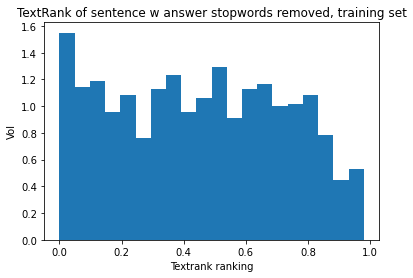

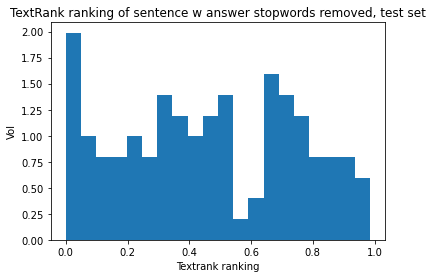

In [ ]:
textrank_locations_no_stopwords_train = find_textrank_rankings(results_df_no_stopwords_train)
plot_textrank_stats(textrank_locations_no_stopwords_train, 'TextRank of sentence with answer (stopwords removed), training set', 20)
textrank_locations_w_stopwords_train = find_textrank_rankings(results_df_w_stopwords_train)
plot_textrank_stats(textrank_locations_w_stopwords_train, 'TextRank of sentence with answer, training set', 20)

textrank_locations_no_stopwords_test = find_textrank_rankings(results_df_no_stopwords_test)
plot_textrank_stats(textrank_locations_no_stopwords_test, 'TextRank ranking of sentence with answer (stopwords removed), test set', 20)
textrank_locations_w_stopwords_test = find_textrank_rankings(results_df_w_stopwords_test)
plot_textrank_stats(textrank_locations_w_stopwords_test, 'TextRank ranking of sentence with answer, test set', 20)